### The difference between this notebook and `Pre-processing-Orig` is that some explanation is added here for areas that were explained verbally

In [2]:
# Setup the package, this is done automatically with the startup scripts
import os
import sys

# Setup some constants
HOME = os.path.expanduser('~')
NOTEBOOKS_PATH = os.path.join(HOME, 'mantidimaging', 'notebooks')

CHADWICK_PATH = os.path.join(NOTEBOOKS_PATH, 'demoimages')
CHADWICK_SAMPLE_PATH = os.path.join(CHADWICK_PATH, 'sample')
CHADWICK_DARK_PATH = os.path.join(CHADWICK_PATH, 'dark')
CHADWICK_FLAT_PATH = os.path.join(CHADWICK_PATH, 'flat')

CHADWICK_OUTPUT_PREPROC_PATH = os.path.join(CHADWICK_PATH, 'preproc')
CHADWICK_OUTPUT_PREPROC_MLOG_PATH = os.path.join(CHADWICK_PATH, 'preproc-mlog')

MANTIDIMAGING_PATH = os.path.join(HOME, 'mantidimaging')
print("Home Dir ->", HOME, "\nDataset Path ->", CHADWICK_PATH, "\nPackage Path ->", MANTIDIMAGING_PATH)
# Append the ISIS Imaging path so that Python can find the package
sys.path[0] = MANTIDIMAGING_PATH

import mantidimaging
print("Package name ->", mantidimaging.__package__)

Home Dir -> /home/dtasev 
Dataset Path -> /home/dtasev/mantidimaging/notebooks/demoimages 
Package Path -> /home/dtasev/mantidimaging
Package name -> mantidimaging


In [8]:
# This step will unpack the archive in the notebooks folder
import tarfile
file = tarfile.open(os.path.join(NOTEBOOKS_PATH, 'demoimages.tar.lzma'), mode='r:xz')
file.extractall(os.path.join(NOTEBOOKS_PATH)) 

In [9]:
import matplotlib

# Setup matplotlib to use the notebook backend, this will allow us to show images/histograms in here
matplotlib.use('nbagg')

from matplotlib import pyplot

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Loading data

In [10]:
# Load some data in, format for indices is [start, end, step]
# for this demonstration we only have 2 images
# if no indices are specified all data will be loaded

indices = [0, 2, 1]
images = mantidimaging.core.io.loader.load(CHADWICK_SAMPLE_PATH, CHADWICK_FLAT_PATH, CHADWICK_DARK_PATH, indices=indices)
print(images.get_sample().shape)

(2, 512, 512)


In [11]:
# The file returned is of a type Images, it allows us to transfer metadata with the images, 
# such as the filenames. The filenames are used in the GUI to show the current slice's original file name
assert isinstance(images, mantidimaging.core.io.loader.Images)

# print the public methods
list(filter(lambda x: "__" not in x, dir(mantidimaging.core.io.loader.Images)))

['check_data_stack', 'get_dark', 'get_filenames', 'get_flat', 'get_sample']

In [12]:
# Use matplotlib to build a small plotting window that visualises the image and a histogram
def show(image):
    fig, img_axes = pyplot.subplots(nrows=1,ncols=1)
    
    image_obj = img_axes.imshow(image.get_sample()[0], cmap='Greys_r')
    
    hist_axes = fig.add_axes([0.25, 0.925, 0.5, 0.08])
    hist_axes.hist(image.get_sample()[0].flatten(), bins=2048)

    pyplot.show()
    
# Due to this being added at a later time, show was already used a few times and I didn't want to break them
# This uses the image argument directly instead of accessing the .get_sample() method
def show2(image):
    fig, img_axes = pyplot.subplots(nrows=1,ncols=1)
    
    image_obj = img_axes.imshow(image, cmap='Greys_r')
    
    hist_axes = fig.add_axes([0.25, 0.925, 0.5, 0.08])
    hist_axes.hist(image.flatten(), bins=2048)

    pyplot.show()

<IPython.core.display.Javascript object>


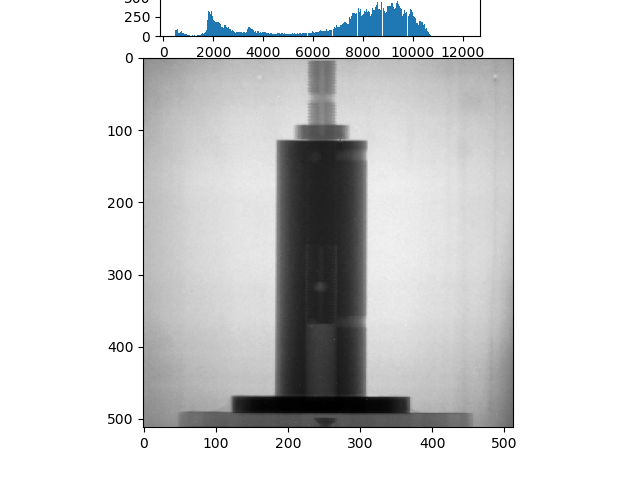

In [16]:
# Show the sample projection, these would be the images taken during the experiment with the sample inside
show(images)

<IPython.core.display.Javascript object>


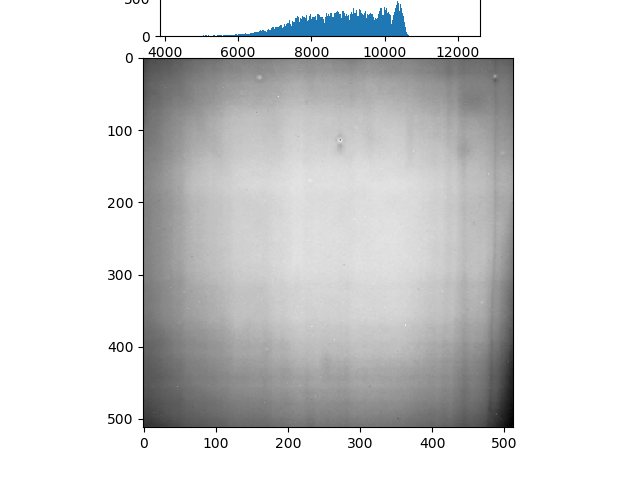

In [14]:
# Flat and Dark images are usually between 30-60, 
# but we load all of them in and then take the average of all the images

# Flat images are also called Open Beam Images. 
# They are taken after the instrument/experiment is set up, 
# but without the sample inside. This gives the more-or-less static
# background that the projections will have during the experiment

show2(images.get_flat())

<IPython.core.display.Javascript object>


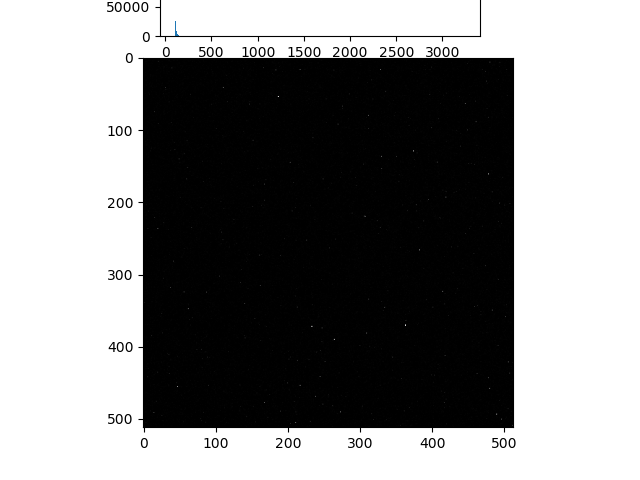

In [15]:
# Dark images are gathered from just running the camera without a beam and on a closed shutter
# This shows showing any bad pixels that the camera itself might have
show2(images.get_dark())

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Background Correction

 ---Starting PARALLEL normalization by flat/dark images.
 ---Finished PARALLEL normalization by flat/dark images. Elapsed time: 0.3991084098815918 sec.


<IPython.core.display.Javascript object>


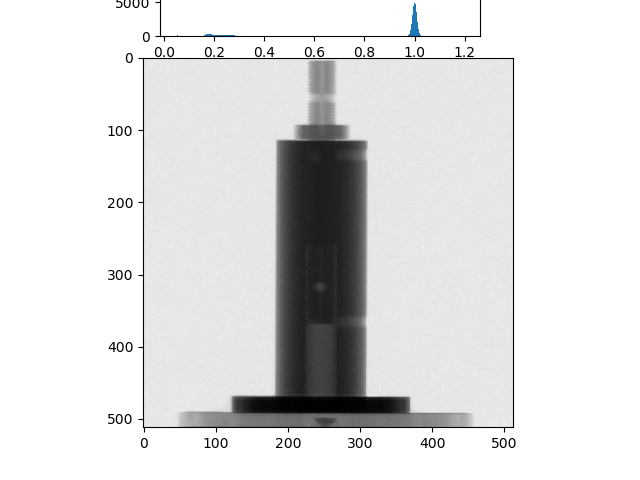

In [17]:
from mantidimaging.core.algorithms import value_scaling
from mantidimaging.core.filters import background_correction

# Calculate scale factors, so that we can scale up the values 
# after ROI normalisation (more details in next step)
scale_factors = value_scaling.create_factors(images.get_sample())

# Background Correction
# We need sample, flat (open beam without an object) and dark (closed shutter) images
background_correction.execute(images.get_sample(), images.get_flat(), images.get_dark())

# show result
show(images)

In [18]:
# import package from isis_imaging's GUI part
from mantidimaging.gui.stack_visualiser import sv_histogram

# python abuse to plot the histograms on the same plot, it works by default in the package

def plot_histograms_magically():
    # save the original function reference
    temp_func_storage = sv_histogram._show
    def _temporary_empty_function(): pass
    
    # set to a function that does nothing
    sv_histogram._show = _temporary_empty_function

    sv_histogram.show_transparent(images.get_sample()[0].flatten(), "Normal Contrast", "")

    # restore so that the plot is shown next time
    sv_histogram._show = temp_func_storage

    sv_histogram.show_transparent(images.get_sample()[1].flatten(), "Low Contrast", "Magic")

<IPython.core.display.Javascript object>


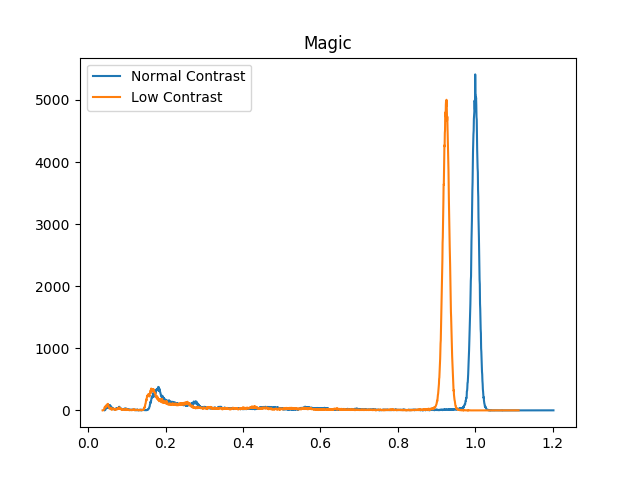

In [19]:
plot_histograms_magically()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Normalisation by Region of Interest

In [20]:
AIR_REGION = (397, 28, 476, 130)
print("Air Region", *AIR_REGION)



# Normalisation by Air Region (Contrast Normalisation)

from mantidimaging.core.filters import roi_normalisation

# Normalise by region of interest
roi_normalisation.execute(images.get_sample(), AIR_REGION)

# and scale up the values to uint16 range (0-65535)
# This is necessary otherwise in reconstruction we reach the end of
# float32 precision, because we get very small values.
value_scaling.apply_factor(images.get_sample(), scale_factors)

Air Region 397 28 476 130
 ---Starting normalization by air region...
 ---Finished normalization by air region. Average: 0.9626775979995728, max ratio: 1.0390522480010986, min ratio: 0.9609478116035461. Elapsed time: 0.43018555641174316 sec.


array([[[ 6965.90722656,  7063.05273438,  7006.13574219, ...,
          6908.92285156,  6974.43017578,  7017.02148438],
        [ 6972.81982422,  6984.70947266,  6987.14453125, ...,
          6923.53955078,  6900.35693359,  6868.42529297],
        [ 7018.89453125,  6994.37109375,  7030.67285156, ...,
          6938.19970703,  6955.79443359,  6861.32666016],
        ..., 
        [ 6951.27392578,  6936.33349609,  6950.31640625, ...,
          6995.90527344,  7085.17138672,  7052.66796875],
        [ 6958.69628906,  6987.49755859,  6978.49462891, ...,
          6926.4453125 ,  6987.79492188,  7009.23828125],
        [ 6935.98974609,  6928.75488281,  6972.31689453, ...,
          6906.82617188,  6920.48486328,  6883.39257812]],

       [[ 6916.39746094,  6926.72607422,  6987.18945312, ...,
          6972.35839844,  6942.50048828,  7004.34619141],
        [ 6886.60742188,  6906.67578125,  7003.87304688, ...,
          6906.84130859,  6952.07519531,  6982.02539062],
        [ 6961.93652344,

<IPython.core.display.Javascript object>


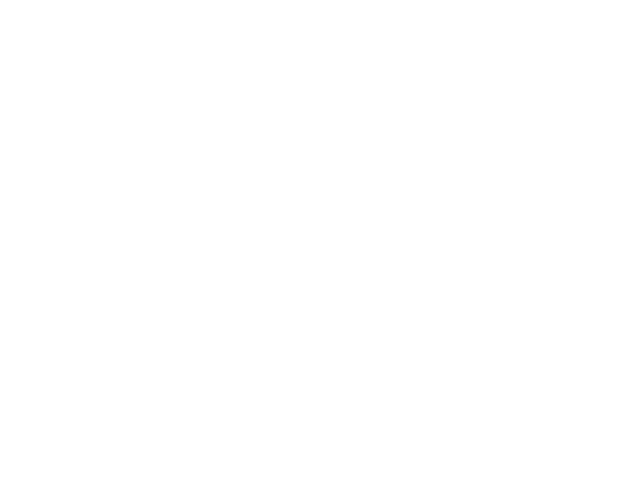

<IPython.core.display.Javascript object>


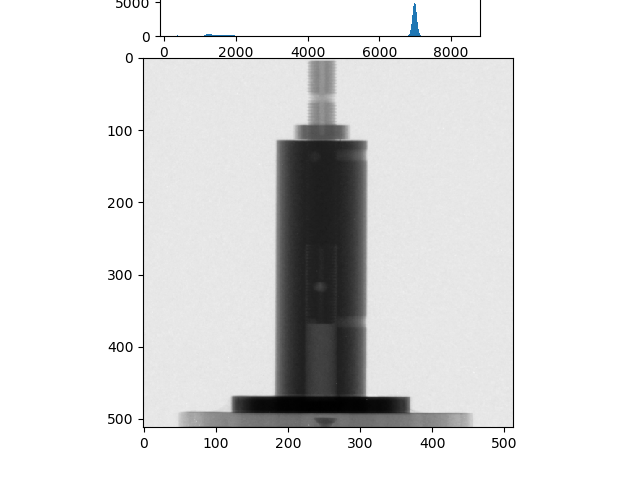

In [21]:
show(images)

<IPython.core.display.Javascript object>


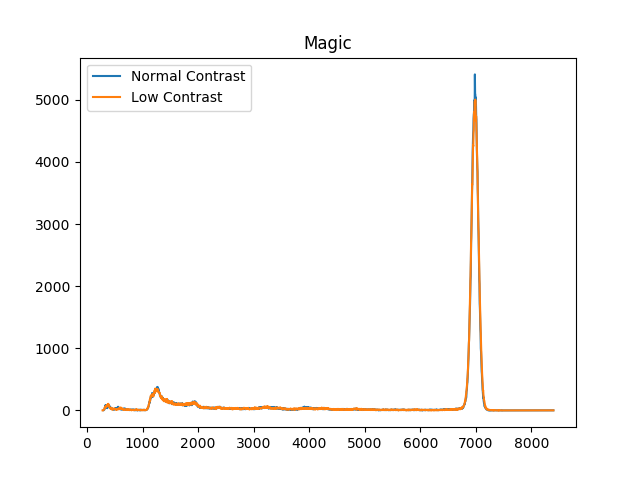

In [22]:
plot_histograms_magically()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Region of Interest crop

In [23]:
ROI = (121, 6, 378, 499)
print("ROI", *ROI)

from mantidimaging.core.filters import crop_coords

print("The Region of Interest that we are cropping", ROI)
images.sample, images.flat, images.dark = crop_coords.execute(images.get_sample(), ROI)

ROI 121 6 378 499
The Region of Interest that we are cropping (121, 6, 378, 499)
 ---Starting cropping with coordinates: (121, 6, 378, 499). ...
 ---Finished image cropping with pixel data type: float32, resulting shape: (2, 493, 257). Elapsed time: 0.00015783309936523438 sec.


<IPython.core.display.Javascript object>


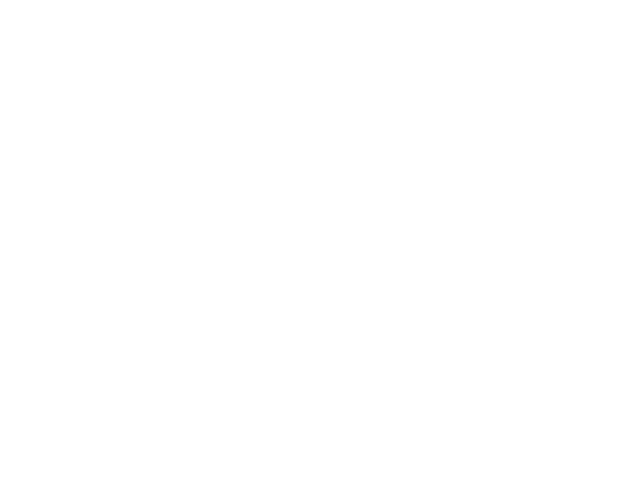

<IPython.core.display.Javascript object>


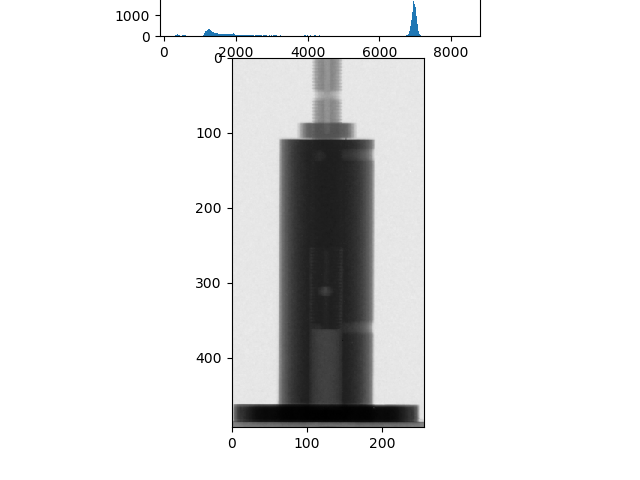

In [24]:
show(images)

<IPython.core.display.Javascript object>


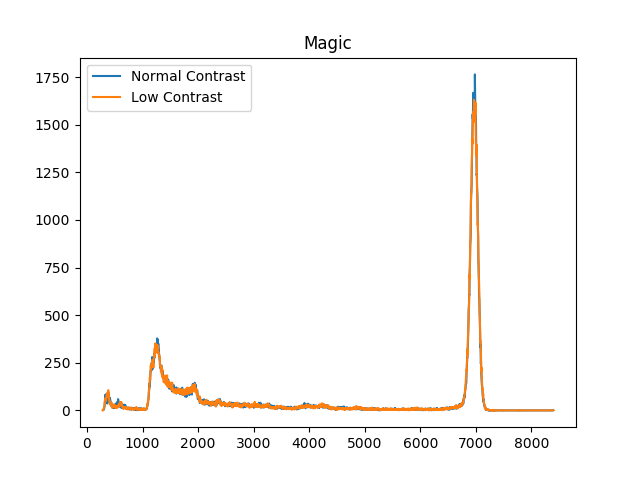

In [25]:
plot_histograms_magically()

## We have not removed _any_ of the data!
## But the noise counts are now a lot less
### Before: 120,000
### Now: 42,000

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Reducing the noise further

### Values of noise and data are very distinct

<IPython.core.display.Javascript object>


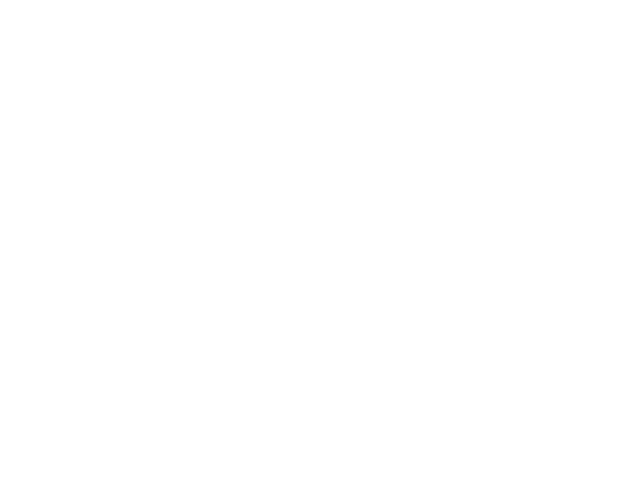

<IPython.core.display.Javascript object>


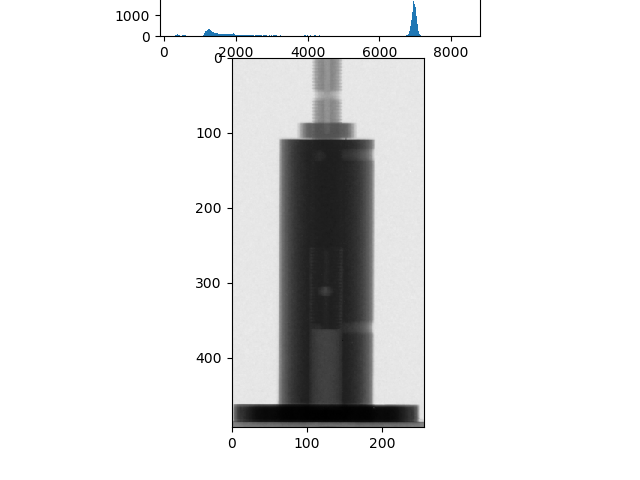

<IPython.core.display.Javascript object>


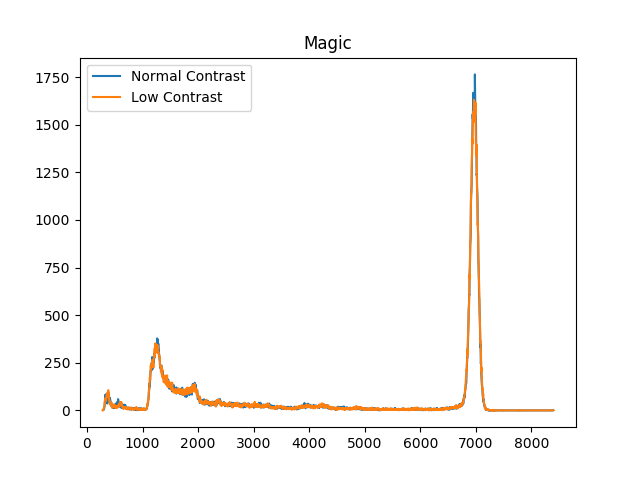

In [26]:
show(images)
plot_histograms_magically()

In [27]:
CLIP_MIN = 0.01
CLIP_MAX = 6200

from mantidimaging.core.filters import clip_values

print("Remove minimum values", CLIP_MIN)
print("Remove maximum values", CLIP_MAX)
clip_values.execute(images.get_sample(), CLIP_MIN, CLIP_MAX)

# save the image out
mantidimaging.core.io.saver.save(images.get_sample(), CHADWICK_OUTPUT_PREPROC_PATH)

Remove minimum values 0.01
Remove maximum values 6200
 ---Clipping data with values min 0.01 and max 6200.
 ---Finished data clipping. Elapsed time: 0.0012538433074951172 sec.


<IPython.core.display.Javascript object>


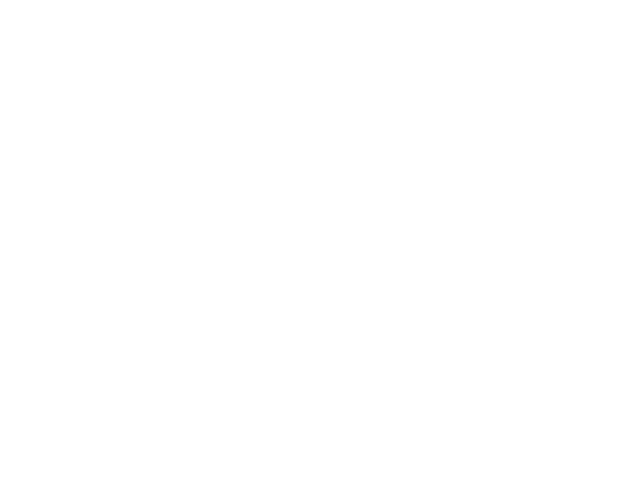

<IPython.core.display.Javascript object>


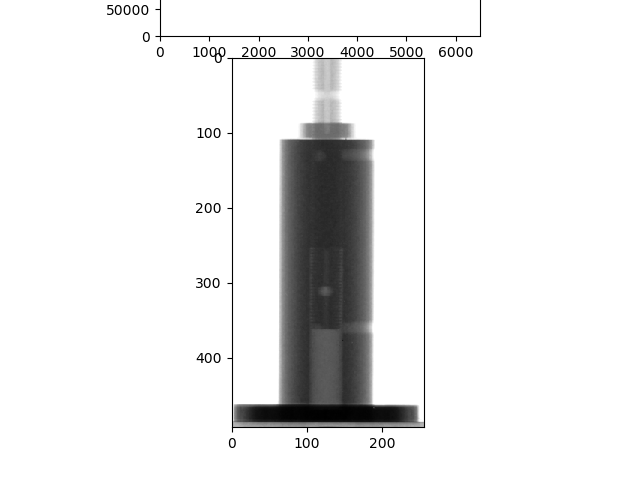

In [28]:
show(images)

<IPython.core.display.Javascript object>


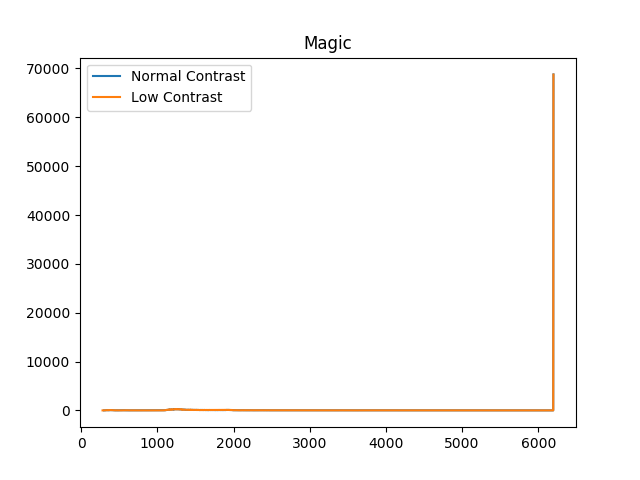

In [29]:
plot_histograms_magically()

In [30]:
from mantidimaging.core.filters import minus_log

# Invert the histogram and reduce the range
images.sample = minus_log.execute(images.get_sample())

# save the image out
mantidimaging.core.io.saver.save(images.get_sample(), CHADWICK_OUTPUT_PREPROC_MLOG_PATH)

 ---Calculating -log on the sample data.
 ---Finished calculating -log on the sample data. Elapsed time: 0.004495143890380859 sec.


<IPython.core.display.Javascript object>


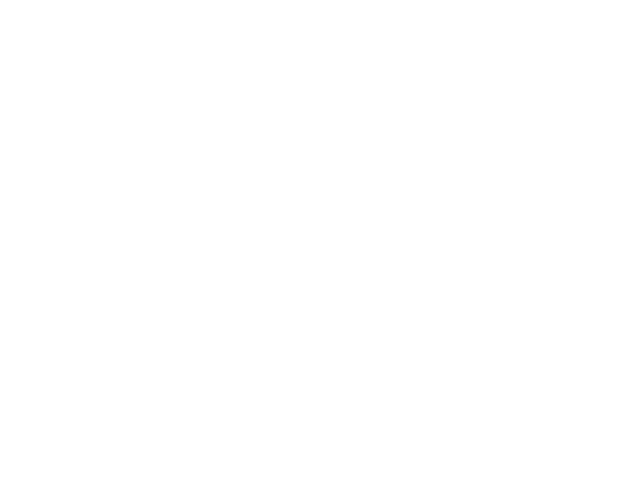

<IPython.core.display.Javascript object>


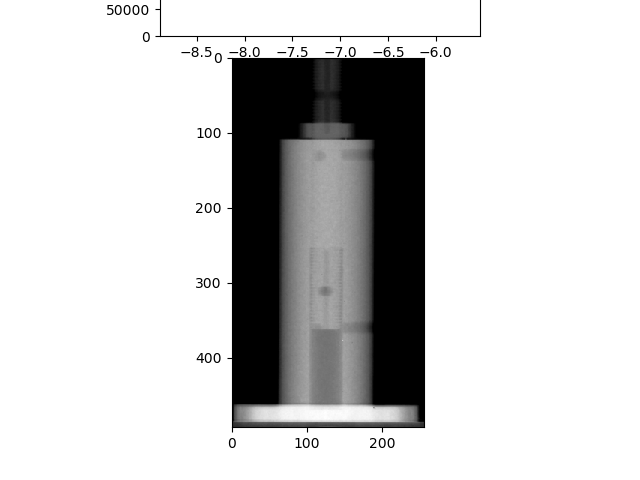

In [31]:
show(images)

<IPython.core.display.Javascript object>


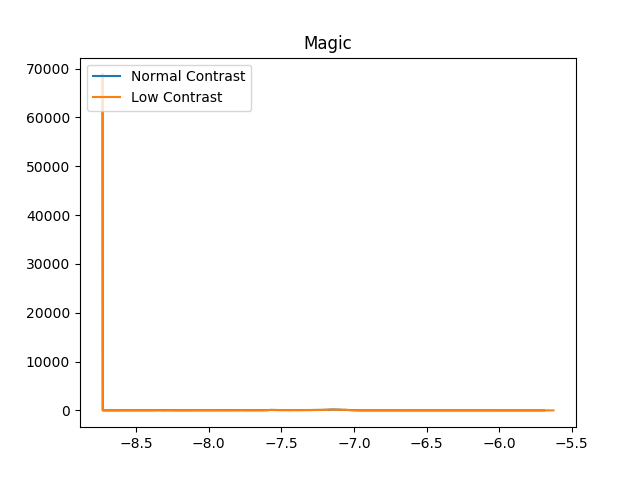

/home/dtasev/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [32]:
plot_histograms_magically()